In [ ]:
# ! pip install matplotlib torch torchvision

In [ ]:
# ! pip install tensorboard jupyter-tensorboard

In [ ]:
# ! pip install torchvision

In [ ]:
# ! pip install tensorboard

In [ ]:
# ! pip install -U gdown

In [ ]:
# !pip install gdown

In [ ]:
# ! pip install Pillow

In [ ]:
# ! pip install opencv-python

In [ ]:
# ! pip install tensorboard

In [ ]:
# ! pip install tqdm

**Загрузка данных**

In [1]:
import os
import cv2
import glob
import torch
import random
import zipfile
import functools
import torchvision
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import matplotlib_inline
import numpy.testing as npt
from torchvision import models
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image, ImageEnhance
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import Image, ImageEnhance, ImageOps
from PIL import ImageEnhance, Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg13, VGG13_Weights
from torchvision.transforms.functional import to_tensor
from torchvision.transforms import Compose, ToTensor, Normalize

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
%load_ext tensorboard
import torch.optim as optim
import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving people_data.zip to people_data.zip
User uploaded file "people_data.zip" with length 22875010 bytes


In [1]:
# !unzip -o people_data.zip -d .

In [ ]:
# !ls /content

In [4]:
train_image_path = 'people_data/train'
train_mask_path = 'people_data/train_mask'

In [5]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):

        self.images_dir, self.target_dir = images_dir, target_dir
        self.images = sorted(os.listdir(self.images_dir))
        self.masks = sorted(os.listdir(self.target_dir))
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.target_dir, self.masks[idx])

        image, mask = Image.open(image_path).convert('RGB'), Image.open(mask_path).convert('L')

        if self.transforms is not None:
            return self.transforms(image, mask)
        return image, mask

In [6]:
class RandomHorizontalFlip:
    def __init__(self, p):
        self.p = p

    def __call__(self, image, mask):
        if random.random() < self.p:
            return image.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
        return image, mask

In [7]:
class RandomCrop:
    def __init__(self, p, max_w, max_h):
        self.p = p
        self.max_w = max_w
        self.max_h = max_h

    def __call__(self, image, mask):
        if random.random() < self.p:
            w, h = image.size
            crop_w = random.randint(0, min(w, self.max_w))
            crop_h = random.randint(0, min(h, self.max_h))

            left = random.randint(0, w - crop_w)
            top = random.randint(0, h - crop_h)

            black_rec = Image.new('RGB', (crop_w, crop_h), (0, 0, 0))

            image.paste(black_rec, (left, top))
            mask.paste(black_rec, (left, top))

        return image, mask


In [8]:
class RandomBrightness:
    def __init__(self, p, br_range=(0.5, 2.0)):
        self.p = p
        self.br_range = br_range

    def __call__(self, image, mask):
        if random.random() < self.p:
            br_factor = random.uniform(*self.br_range)
            enchancer = ImageEnhance.Brightness(image)
            image = enchancer.enhance(br_factor)

        return image, mask

In [9]:
class RandomBackground:
    def __init__(self, p, backgrounds_path):
        self.p = p
        self.backgrounds = [os.path.join(backgrounds_path, _) for _ in os.listdir(backgrounds_path)]

    def __call__(self, image, mask):
        if random.random() < self.p:
            background = Image.open(random.choice(self.backgrounds)).convert('RGB')
            background = background.resize(image.size)

            image_np, mask_np = np.array(image), np.array(mask)
            background_np = np.array(background)
            mask_np = np.tile(mask_np[: ,: ,None], (1, 1, 3)) == 255
            combined_np = (
                mask_np * image_np +
                ~mask_np * background_np
            )
            image = Image.fromarray(combined_np, mode='RGB')

        return image, mask

In [10]:
class ToTensor:
    def __call__(self, image, mask):
        return torchvision.transforms.ToTensor()(image), torchvision.transforms.ToTensor()(mask)

In [11]:
class Normalize:
    def __init__(self, *args, **kwargs):
        self._trainsform = torchvision.transforms.Normalize(*args, **kwargs)
    def __call__(self, image, mask):

        return self._trainsform(image), mask

In [12]:
class Compose:
    def __init__(self, *transforms):
        self.transforms = transforms
    def __call__(self, image, mask):
        for transform in self.transforms:
            image, mask = transform(image, mask)
        return image, mask

In [13]:
dataset = PhotosDataset(
    train_image_path, train_mask_path,
    transforms= Compose(
        RandomHorizontalFlip(p=0.5),
        RandomCrop(p=0.5, max_w = 100, max_h = 100),
        RandomBrightness(p=0.5),
        RandomBackground(p=0.5, backgrounds_path = 'backgrounds'),

        )
    )

In [14]:
DATA_PATH = 'people_data'

train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=Compose(
        RandomHorizontalFlip(p=0.5),
        RandomCrop(p=0.5, max_w = 100, max_h = 100),
        RandomBrightness(p=0.5),
        RandomBackground(p=0.5, backgrounds_path = 'backgrounds'),
        ToTensor(),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    )
)

test_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'test'),
    target_dir=os.path.join(DATA_PATH, 'test_mask'),
    transforms=Compose(
        ToTensor(),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    )
)

In [15]:
def show_idx_image(dataset, idx):
    image, mask = dataset[idx]

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(image)
    axes[1].imshow(mask)

    axes[0].set_axis_off()
    axes[1].set_axis_off()

    fig.tight_layout()
    plt.show()

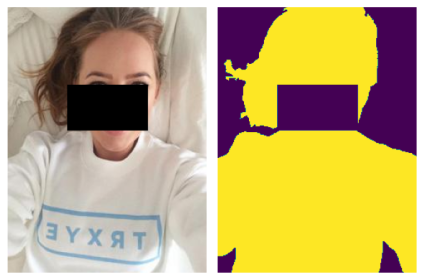

In [16]:
show_idx_image(train_dataset, 0)

In [17]:
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=0)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=0, shuffle=True)

In [18]:
images, masks = next(iter(train_data_loader))

In [19]:
images.shape, masks.shape

(torch.Size([8, 3, 320, 240]), torch.Size([8, 1, 320, 240]))

In [20]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7, reduction='mean', with_logits=True):
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits

    def forward(self, logits, true_labels):
        true_labels = true_labels.to(torch.long)

        if self.with_logits:
            logits = torch.sigmoid(logits)

        dice_loss = 1 - 2 * (
            torch.sum(logits * true_labels, dim = (-1, -2)) /
            torch.sum(logits + true_labels + self.eps, dim = (-1, -2))
        )

        if self.reduction == 'sum':
            loss_value = torch.sum(dice_loss)
        elif self.reduction == 'mean':
            loss_value = torch.mean(dice_loss)
        elif self.reduction is None:
            loss_value = dice_loss
        return loss_value

In [21]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

In [22]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks
        feature_extractor = vgg13(weights=weights).features
        self.blocks = nn.ModuleList()
        for idx in range(self.num_blocks):
            self.blocks.append(
                feature_extractor[idx * 5: idx* 5 + 4 ]
            )
    def forward(self, x):
        activations = []
        for idx, block in enumerate(self.blocks):
            x = block(x)
            activations.append(x)
            if idx != len(self.blocks) - 1:
                x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2, padding=0, dilation=1)
        return activations

In [23]:
assert sum((param.numel() for param in VGG13Encoder(num_blocks=1).parameters())) == 38720
assert sum((param.numel() for param in VGG13Encoder(num_blocks=2).parameters())) == 260160
assert sum((param.numel() for param in VGG13Encoder(num_blocks=3).parameters())) == 1145408

x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)
out = VGG13Encoder(num_blocks=3)(x)

assert len(out) == 3
npt.assert_almost_equal(torch.linalg.norm(out[0]).item(), 902.218, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[1]).item(), 571.030, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[2]).item(), 648.068, decimal=3)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:06<00:00, 85.9MB/s]


In [24]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = torch.cat([x, left], dim = 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

In [25]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

In [26]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            64, num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

In [27]:
model = UNet(num_classes=1, num_blocks=3)
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) == 2067649
assert list(model(x).shape) == [1, 1, 320, 240]
model

UNet(
  (encoder): VGG13Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
      )
      (2): Sequential(
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
      )
    )
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0): DecoderBlock(
        (upconv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [28]:
class IoUScore(torch.nn.Module):
    def __init__(self, threshold, with_logits=False, reduction=None):

        super().__init__()

        self.threshold = threshold
        self.reduction = reduction
        self.with_logits = with_logits

    @torch.no_grad()
    def forward(self, logits, true_labels):

        if self.with_logits:
            logits = torch.sigmoid(logits)

        prediction_mask = (logits > self.threshold).to(torch.long)

        iou = (
            torch.sum(prediction_mask * true_labels, dim = (-1, -2)) /
            torch.sum(prediction_mask + true_labels - prediction_mask * true_labels, dim = (-1, -2))

        )

        if self.reduction == 'sum':
            score = torch.sum(iou)
        elif self.reduction == 'mean':
            score = torch.mean(iou)
        else:
            score = iou
        return score

In [29]:
logits = torch.tensor([
    [
        [0.3089,  0.4311, -0.9711],
        [0.9030,  1.0325, -0.7607],
        [0.9648, -0.5528, -1.1010]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ]
])
true_labels = torch.tensor([
    [
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], [
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 0.]
    ], [
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]
    ]
])

scores = IoUScore(0.0)(logits, true_labels)
npt.assert_almost_equal(scores.numpy(), np.array([0.3333, 1.0000, 0.5556]), decimal=4)

score = IoUScore(0.0, reduction='sum')(logits, true_labels)
npt.assert_almost_equal(score.item(), 1.8889, decimal=4)

score = IoUScore(0.0, reduction='mean')(logits, true_labels)
npt.assert_almost_equal(score.item(), 0.6296, decimal=4)

In [30]:
bce_loss_fn = torch.nn.BCEWithLogitsLoss()
dice_loss_fn = DiceLoss(reduction = 'mean', with_logits = True,)
iou_score_fn = IoUScore(reduction = 'mean', with_logits = True, threshold = 0.5)

In [31]:
@torch.no_grad()
def evaluate(model, dataloader, alpha, device):
    model.eval()

    n_objects = 0
    bce_loss, dice_loss, iou_score, loss = 0.0, 0.0, 0.0, 0.0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs=model(images)

        n_objects += images.shape[0]
        bce_loss_bath = bce_loss_fn(outputs, masks)
        dice_loss_bath = dice_loss_fn(outputs, masks)
        iou_score_bath = iou_score_fn(outputs, masks)
        loss_bath = alpha * bce_loss_bath + (1 - alpha) * dice_loss_bath

        bce_loss += bce_loss_bath * images.shape[0]
        dice_loss += dice_loss_bath * images.shape[0]
        iou_score += iou_score_bath * images.shape[0]
        loss += loss_bath * images.shape[0]

    return bce_loss / n_objects, dice_loss / n_objects, iou_score / n_objects, loss / n_objects

In [32]:
# import tqdm.autonotebuk as tqdm
import tqdm.auto as tqdm

In [33]:
def train(model, optimizer, train_dataloader, test_dataloader, alpha, device, num_epochs):
    model.train()

    for idx in range (num_epochs):

        n_objects = 0
        bce_loss, dice_loss, iou_score, loss = 0.0, 0.0, 0.0, 0.0

        pbar = tqdm.tqdm(train_dataloader, total=len(train_dataloader))
        for images, masks in pbar:
            optimizer.zero_grad()

            images, masks = images.to(device), masks.to(device)
            outputs=model(images)

            n_objects += images.shape[0]
            bce_loss_bath = bce_loss_fn(outputs, masks)
            dice_loss_bath = dice_loss_fn(outputs, masks)
            iou_score_bath = iou_score_fn(outputs, masks)
            loss_bath = alpha * bce_loss_bath + (1 - alpha) * dice_loss_bath

            pbar.set_description(
                'BCE loss: {0:.3f}, Dice loss: {1:.3f}, Iou: {2:.3f}, Loss: {3:.3f}'.format(
                    bce_loss_bath, dice_loss_bath, iou_score_bath, loss_bath
                )
            )

            bce_loss += bce_loss_bath * images.shape[0]
            dice_loss += dice_loss_bath * images.shape[0]
            iou_score += iou_score_bath * images.shape[0]
            loss += loss_bath * images.shape[0]

            loss_bath.backward()
            optimizer.step()

        print('BCE loss: {0:.3f}, Dice loss: {1:.3f}, Iou: {2:.3f}, Loss: {3:.3f}'.format(
            bce_loss / n_objects, dice_loss / n_objects, iou_score / n_objects, loss / n_objects
            )
        )

        bce_los, dice_loss, iou_score, loss = evaluate(model, test_dataloader, alpha, device)

        print('Test\nBCE loss: {0:.3f}, Dice loss: {1:.3f}, Iou: {2:.3f}, Loss: {3:.3f}'.format(
            bce_loss, dice_loss, iou_score, loss
            )
        )

In [37]:
device = torch.device('cuda', 0)

In [38]:
model = UNet(num_classes=1, num_blocks=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [47]:
train(model, optimizer, train_data_loader, test_data_loader, alpha=0.5, device=device, num_epochs=10)

  0%|          | 0/169 [00:00<?, ?it/s]

BCE loss: 0.280, Dice loss: 0.137, Iou: 0.829, Loss: 0.209
Test
BCE loss: 378.673, Dice loss: 0.152, Iou: 0.783, Loss: 0.275


  0%|          | 0/169 [00:00<?, ?it/s]

BCE loss: 0.244, Dice loss: 0.116, Iou: 0.852, Loss: 0.180
Test
BCE loss: 329.665, Dice loss: 0.147, Iou: 0.796, Loss: 0.250


  0%|          | 0/169 [00:00<?, ?it/s]

BCE loss: 0.223, Dice loss: 0.106, Iou: 0.866, Loss: 0.164
Test
BCE loss: 300.590, Dice loss: 0.133, Iou: 0.807, Loss: 0.235


  0%|          | 0/169 [00:00<?, ?it/s]

BCE loss: 0.213, Dice loss: 0.102, Iou: 0.870, Loss: 0.158
Test
BCE loss: 287.853, Dice loss: 0.134, Iou: 0.796, Loss: 0.264


  0%|          | 0/169 [00:00<?, ?it/s]

BCE loss: 0.213, Dice loss: 0.101, Iou: 0.870, Loss: 0.157
Test
BCE loss: 288.106, Dice loss: 0.130, Iou: 0.817, Loss: 0.218


  0%|          | 0/169 [00:00<?, ?it/s]

BCE loss: 0.203, Dice loss: 0.097, Iou: 0.875, Loss: 0.150
Test
BCE loss: 274.306, Dice loss: 0.133, Iou: 0.817, Loss: 0.223


  0%|          | 0/169 [00:00<?, ?it/s]

BCE loss: 0.203, Dice loss: 0.097, Iou: 0.876, Loss: 0.150
Test
BCE loss: 274.386, Dice loss: 0.127, Iou: 0.827, Loss: 0.206


  0%|          | 0/169 [00:00<?, ?it/s]

BCE loss: 0.182, Dice loss: 0.086, Iou: 0.889, Loss: 0.134
Test
BCE loss: 245.513, Dice loss: 0.119, Iou: 0.831, Loss: 0.202


  0%|          | 0/169 [00:00<?, ?it/s]

BCE loss: 0.180, Dice loss: 0.085, Iou: 0.890, Loss: 0.132
Test
BCE loss: 242.989, Dice loss: 0.131, Iou: 0.813, Loss: 0.228


  0%|          | 0/169 [00:00<?, ?it/s]

BCE loss: 0.176, Dice loss: 0.083, Iou: 0.892, Loss: 0.130
Test
BCE loss: 237.692, Dice loss: 0.114, Iou: 0.834, Loss: 0.202


In [48]:
image, masks = next(iter(test_data_loader))

In [49]:
predictions = model(images.to(device))

In [50]:
probabilities = torch.sigmoid(predictions)

In [58]:
image = images[0].permute(1, 2, 0).numpy()
image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
image = np.clip(image, 0, 1)

mask = masks[0].squeeze(0).numpy()

probability = probabilities[0].detach().squeeze(0).cpu().numpy()

In [63]:
# fig, axes = plt.subplots(1, 3, figsize = (12, 4))
# axes.imshow()

# axes[0].imshow(image)
# axes[1].imshow(mask)
# # axes[2].imshow(probability)
# axes[2].imshow(probability>0.7)

# plt.show()